In [9]:
import os
from pandas import *
from numpy import *
from H_utility import *

currentdir='/home/adun6414/Work/CERC_UCM'
os.chdir(currentdir)
#os.chdir('/home/adun6414/Work/CERC_UCM/Fig_n_data');
#filename='DATA8to8.csv' #filename='DATA8to9.csv', DATA1to11.csv (2yr data)

filename='DATA1to11.csv'
DATA=read_csv(filename).set_index('Date')
DATA.index=to_datetime(DATA.index)

## Columns of the data file are

In [10]:
DATA.columns

Index(['mcw1', 'mcw2', 'mcw3', 'mcw4', 'mcw5', 'mcwsum', 'Toa', 'RH', 'Twb',
       'PCTtot_x',
       ...
       'TT-47 Temp_y', 'TT-48 Temp_y', 'TT-49 Temp_y', 'TT-50 Temp_y',
       'TT-51 Temp_y', 'TT-52 Temp_y', 'TT-53 Temp_y', 'TT-54 Temp_y',
       'TT-55 Temp_y', 'TT-56 Temp_y'],
      dtype='object', length=144)

## Chiller Correlation Model Development
- my model structure is 
$$ P = f(T_{CHSP},T_{CWS},PRL,m_{CW}) $$
- while energy plus model structure is
$$ Q_{max}/Q_0 = Q_{max,funcT}(T_{CHSP},T_{CWS}) $$
$$ COP=COP_{max,funcT}(T_{CHSP},T_{CWS}) $$
$$ P_{max} = 1/COP \times Q_{max}$$
$$ P = f_{PRL}(PRL) \times P_{max} $$

- Temperature is in oF while Power and heat flow are in kW
- dataiCH: filtered data after truncating small powers (out of my interests) and NaN.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f15f22150b8>,
      dtype=object)

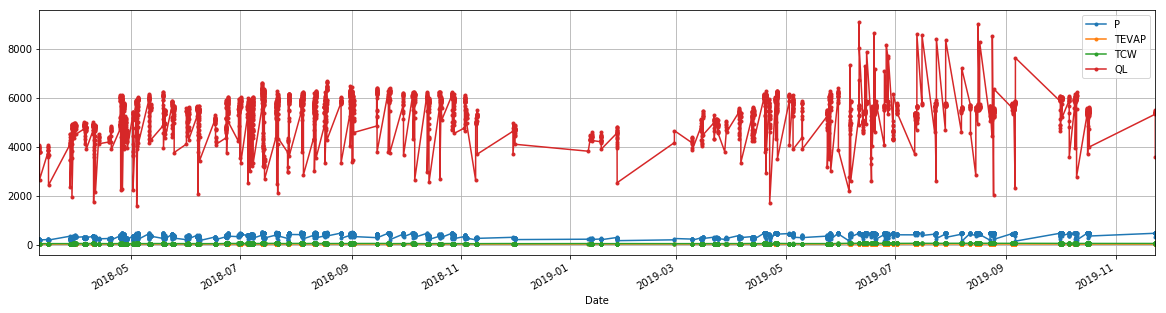

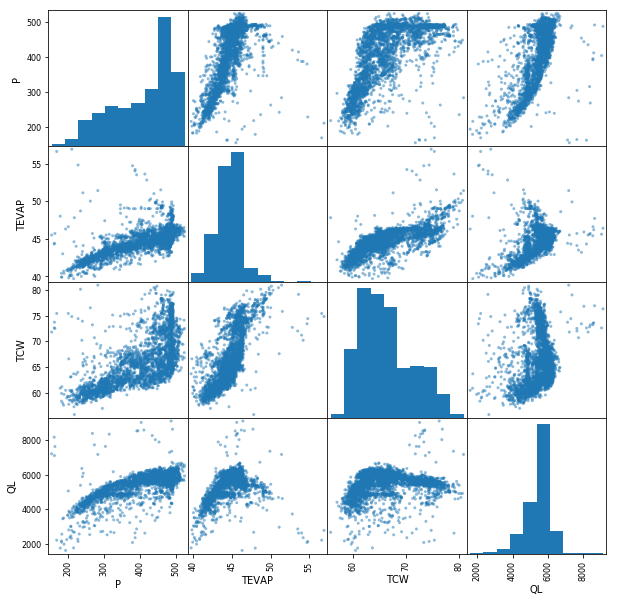

In [11]:
P0=500 #kW: two chillers become 1MW s.t. it can participate XSP
Q0=ton2kW(1500) # almost 10 COP
TEVAP0=38 # oF
TCW0=60
PCH=DATA['MOTOR KW'].to_frame() # kW
QCHL=DATA['QCHL1'].to_frame()   # kW
TEVAP=DATA['TCHe1'].to_frame()   # oF
TCW=DATA['TCWS1'].to_frame()    # oF
dataiCH=DataFrame()
dataiCH=PCH.merge(TEVAP,on='Date')
dataiCH=dataiCH.merge(TCW,on='Date')
dataiCH=dataiCH.merge(QCHL,on='Date')
dataiCH.columns=['P','TEVAP','TCW','QL']
dataiCH=dataiCH[((dataiCH['P']>0.3*500) & (dataiCH['QL']>0.3*ton2kW(1500)))]
dataiCH=dataiCH.dropna()

figure(figsize=(20,5))
ax=subplot(111)
dataiCH.plot(style='.-',grid=True,ax=ax)

figure(figsize=(10,10))
ax=subplot(111)
plotting.scatter_matrix(dataiCH,ax=ax)

In [12]:
## Make a Correlation and Compares with Data

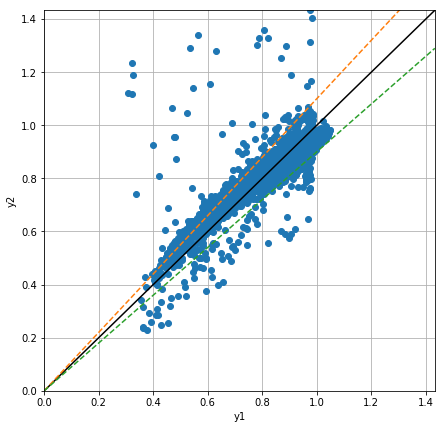

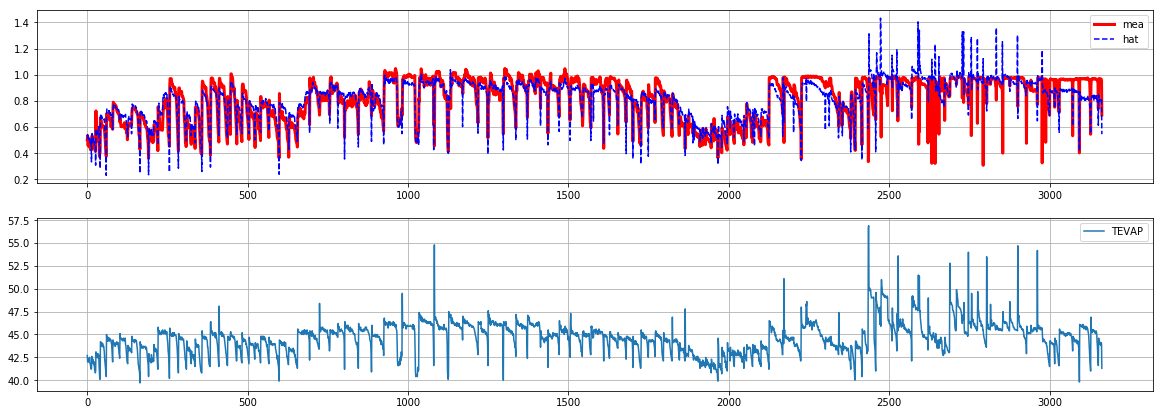

In [14]:
Y=mat(dataiCH.iloc[:,0].to_numpy()/P0).T
onevec=mat(ones((Y.size,1)))
tildeTEVAP=mat((dataiCH.iloc[:,1]-TEVAP0)/10).T
tildeTCW=mat((dataiCH.iloc[:,2]-TCW0)/20).T
tildeQCHL=mat(dataiCH.iloc[:,3]/Q0).T
tildeQCHL2=mat(dataiCH.iloc[:,3]**2/(Q0**2)).T

PHI=hstack((onevec,tildeTEVAP,tildeTCW,tildeQCHL))
theta=linalg.pinv(PHI.T*PHI)*PHI.T*Y
hatY=PHI*theta
figure(figsize=(7,7))
H_plotc(Y,hatY)

figure(figsize=(20,7))
subplot(211)
plot(Y,'r',linewidth=3)
plot(hatY,'b--')
grid(True)
legend(['mea','hat'])
subplot(212)
plot(dataiCH.iloc[:,1:2].to_numpy())
grid(True)
legend(['TEVAP','TCW'])





## Compare the chiller model with original (non filtered) data

In [7]:
hatP=np.array(zeros((PCH.size,1)))
for k in range(PCH.size):
    if QCHL.iloc[k].to_numpy()<0.3*ton2kW(1500):
        hatP[k]=0
    else:
        phiT=mat([1,(TEVAP.iloc[k].to_numpy()-TEVAP0)/10,(TCW.iloc[k].to_numpy()-TCW0)/20, QCHL.iloc[k].to_numpy()/Q0])
        hatP[k]=phiT*theta*P0

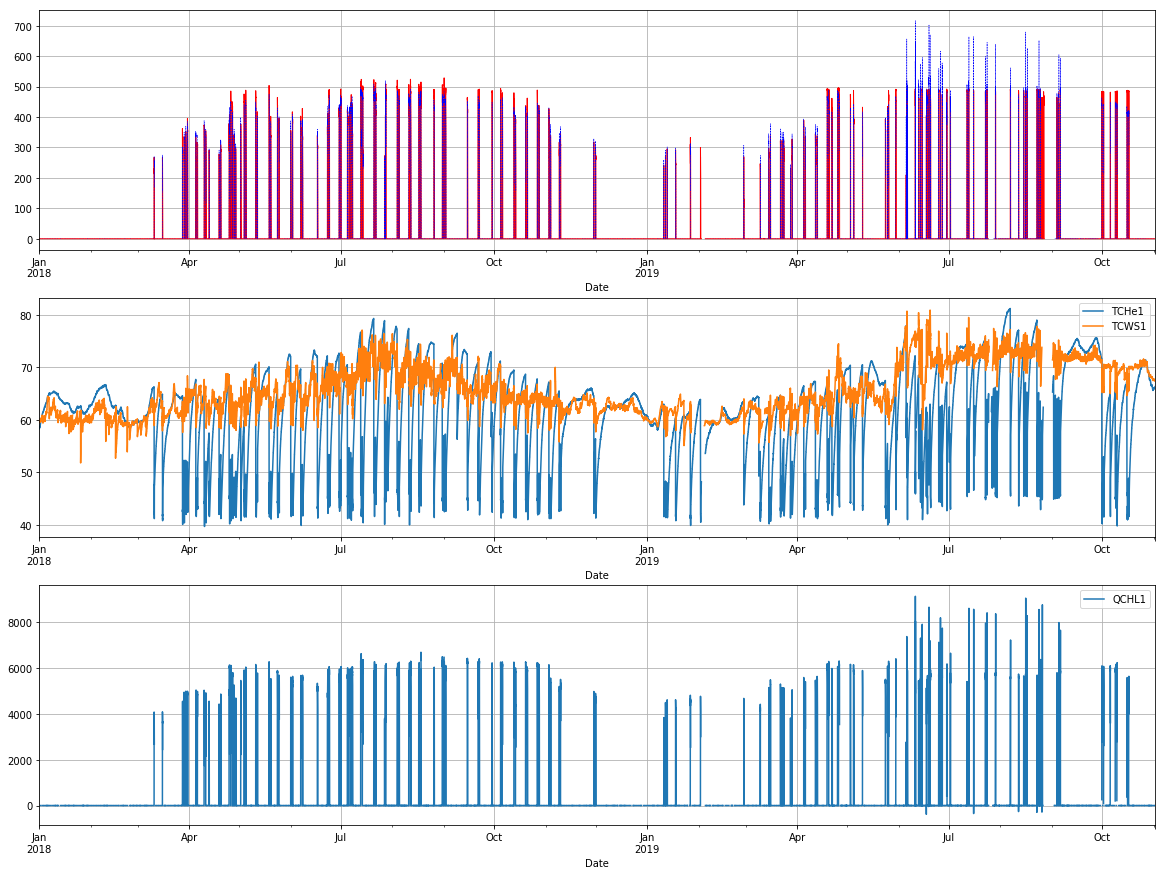

In [24]:
Pow=DataFrame(hstack((PCH.to_numpy(),np.array(hatP))),columns=['mea','hat'])
Pow.index=PCH.index
figure(figsize=(20,15))
ax=subplot(311)
start='2018-01-01'
end='2019-11-01'
Pow['mea'][start:end].plot(style='r',linewidth=1,grid=True,ax=ax);
Pow['hat'][start:end].plot(style='b--',linewidth=0.5,grid=True,ax=ax);
ax=subplot(312)
TEVAP[start:end].plot(grid=True,ax=ax)
TCW[start:end].plot(grid=True,ax=ax)
ax=subplot(313)
QCHL[start:end].plot(grid=True,ax=ax)

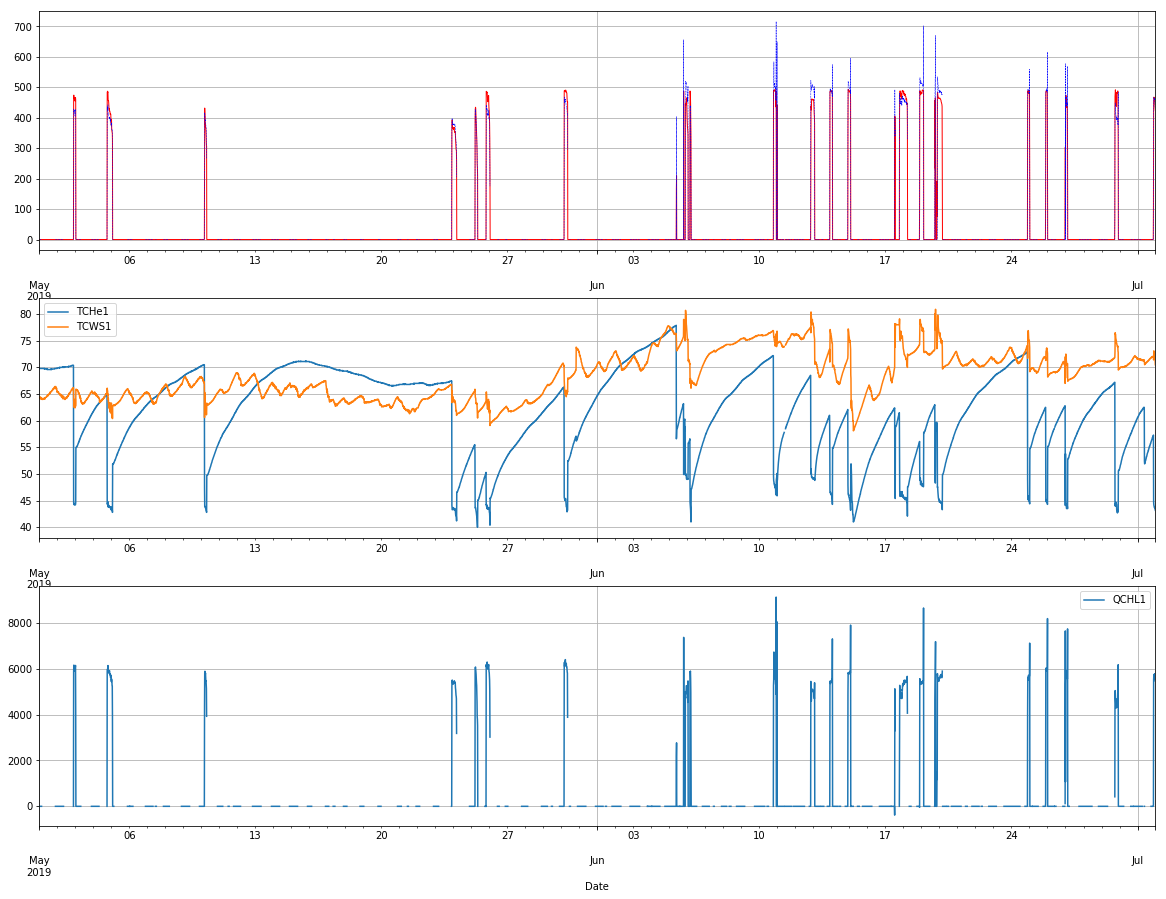

In [25]:
Pow=DataFrame(hstack((PCH.to_numpy(),np.array(hatP))),columns=['mea','hat'])
Pow.index=PCH.index
figure(figsize=(20,15))
ax=subplot(311)
start='2019-05-01'
end='2019-07-01'
Pow['mea'][start:end].plot(style='r',linewidth=1,grid=True,ax=ax);
Pow['hat'][start:end].plot(style='b--',linewidth=0.5,grid=True,ax=ax);
ax=subplot(312)
TEVAP[start:end].plot(grid=True,ax=ax)
TCW[start:end].plot(grid=True,ax=ax)
ax=subplot(313)
QCHL[start:end].plot(grid=True,ax=ax)